# Libs and pre-definitions

### Bibliotecas padrões python e utils pytorch

In [13]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
from collections import defaultdict
from torch.utils.data import random_split
import copy
from matplotlib.pyplot import figure

In [2]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dev = torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [3]:
import NN_models as models
from NN_models import vgg
import uncertainty.comparison as unc_comp
import uncertainty.quantifications as unc
import uncertainty.losses as losses
import uncertainty.train_and_eval_with_g as TE_g
import NN_utils as utils
import NN_utils.train_and_eval as TE
import NN_utils.cifar_def as pre_data

Files already downloaded and verified
Files already downloaded and verified


## Data download and transforms

In [4]:
test_data = pre_data.test_data
test_dataloader = DataLoader(test_data, batch_size=1000)  
#_, _, test_dataloader = pre_data.get_dataloaders()

In [5]:
PATH = r'/home/luis-felipe/Uncertainty_Estimation/torch_models/'
state_dict = torch.load(PATH+'classifier_vgg.pt')

In [6]:
model = utils.identify_from_statedict(state_dict)

Loaded model:  VGG_16


# Analysis

In [36]:
def prob_wrong(mc_preds, main_guess = None):
    '''From samples using montecarlo dropout, returns the probabilitie of argmax(y) being different from the main inference'''
    n = mc_preds.shape[0]
    if main_guess is None: main_guess = torch.mean(mc_preds,dim=0)
    if main_guess.shape[-1] != 1 and len(main_guess.shape) != 1: main_guess = torch.argmax(main_guess,dim=-1)
    guesses_mc = torch.argmax(mc_preds,dim=-1)
    #maxes = torch.max(mc_preds,dim=-1)
    p_dif_list = []

    for i,guess in enumerate(guesses_mc.T):
        difs = torch.sum(guess!=main_guess[i])
        p_dif_list.append(difs.item())
    return np.asarray(p_dif_list)/n
    
    
def entropy(y):
    ent = torch.special.entr(y)
    ent = torch.sum(ent,dim=-1)
    return ent

In [8]:
image,label = next(iter(test_dataloader))
n_samples = 200
model.eval()
preds = torch.exp(model(image))
mc_preds = torch.exp(unc.montecarlo_pred(model,image,n=n_samples))


/home/luis-felipe/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
means = torch.mean(mc_preds,dim=0)
maxes = torch.max(means,dim=-1).values.numpy()
var = torch.mean(torch.var(mc_preds,dim=0),dim=-1).numpy()
guesses = torch.argmax(preds,dim=-1)
guesses_mc = torch.argmax(torch.mean(mc_preds,dim=0),dim=-1)
MCP = torch.max(preds,dim=-1).values.detach().numpy()

In [11]:
print(f'Acurácia com inferência normal: {torch.sum(guesses==label)/label.size(0)}')
print(f'Acurácia com MonteCarloDropout: {torch.sum(guesses_mc==label)/label.size(0)}')

Acurácia com inferência normal: 0.9259999990463257
Acurácia com MonteCarloDropout: 0.9290000200271606


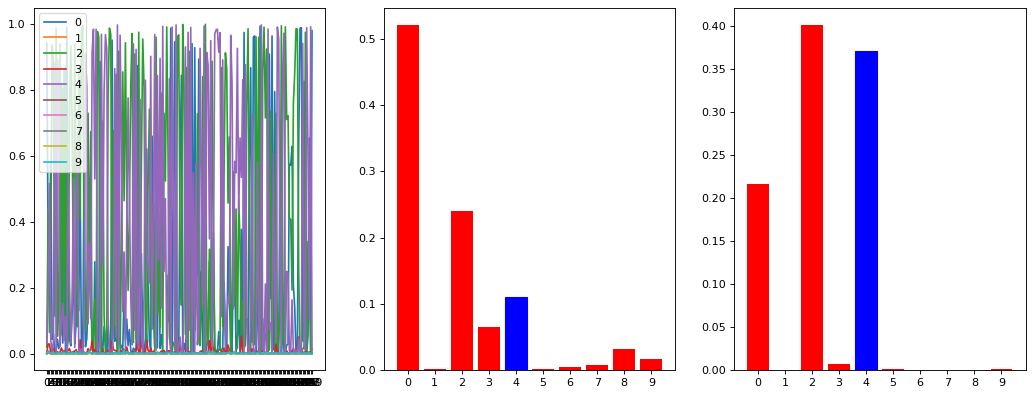

In [20]:
s = torch.argmax(torch.mean(torch.var(mc_preds,dim=0),dim=-1))
sample = mc_preds[:,s,:]
figure(figsize=(16, 6), dpi=80)
plt.subplot(1,3,1)
for i in range(mc_preds.shape[-1]):
    pc = sample[:,i]
    plt.plot(pc,label = i)
plt.xticks(range(n_samples))

plt.legend(loc='upper left')
plt.subplot(1,3,2)
barlist=plt.bar(range(10),preds[s].detach().numpy(),color = 'red')
barlist[label[s]].set_color('b')
plt.xticks(range(10))

plt.subplot(1,3,3)
barlist=plt.bar(range(10),means[s],color = 'red')
barlist[label[s]].set_color('b')
plt.xticks(range(10))

plt.show()


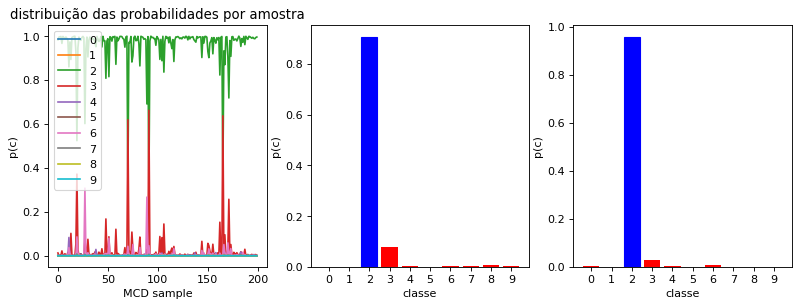

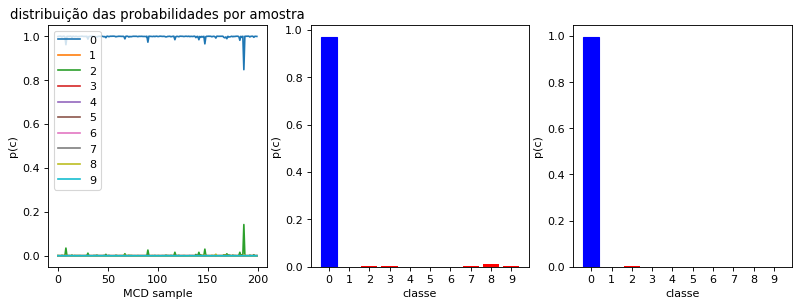

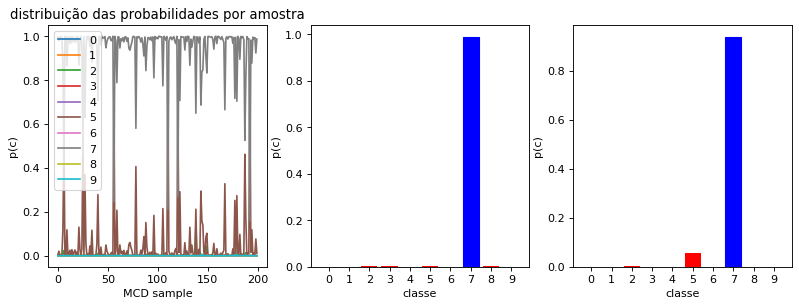

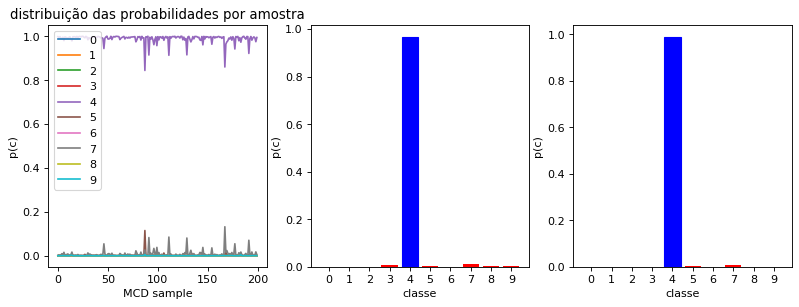

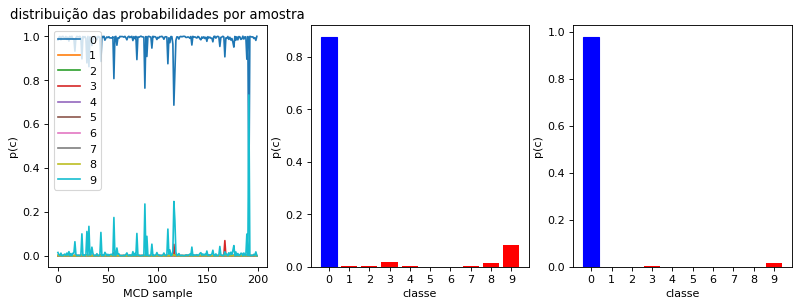

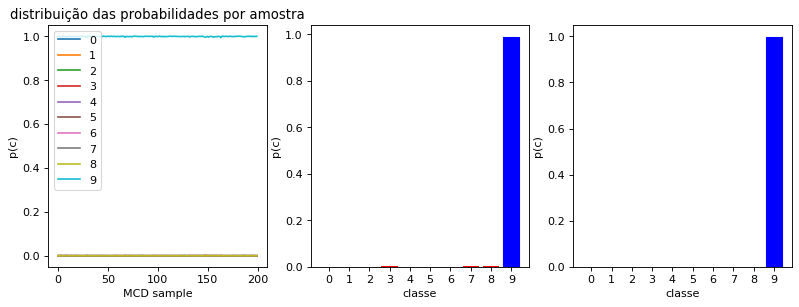

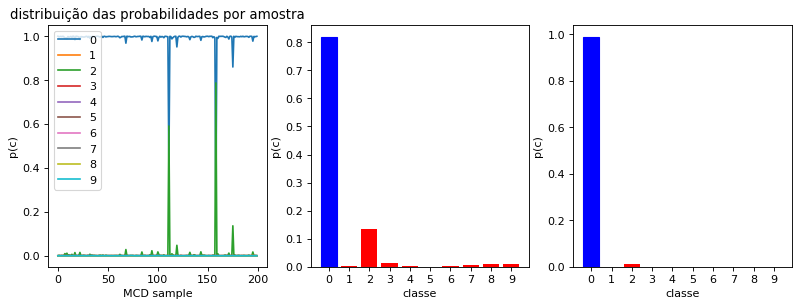

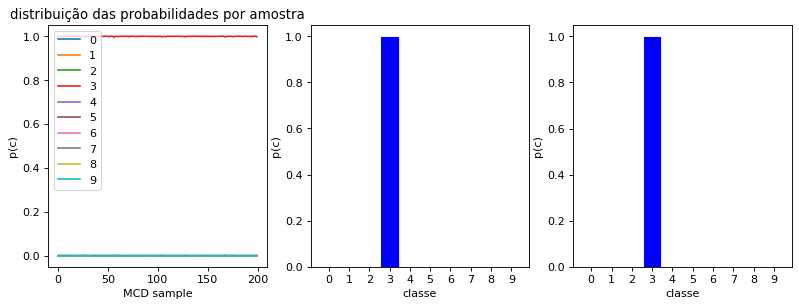

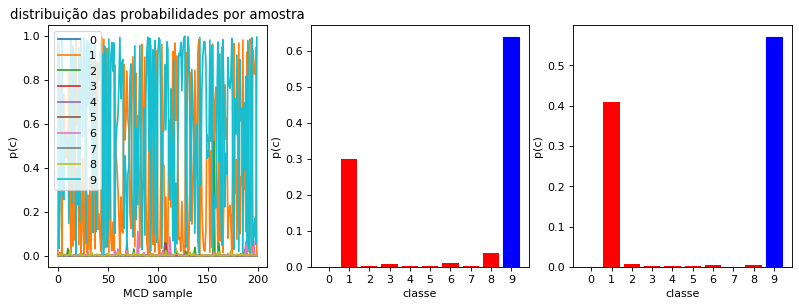

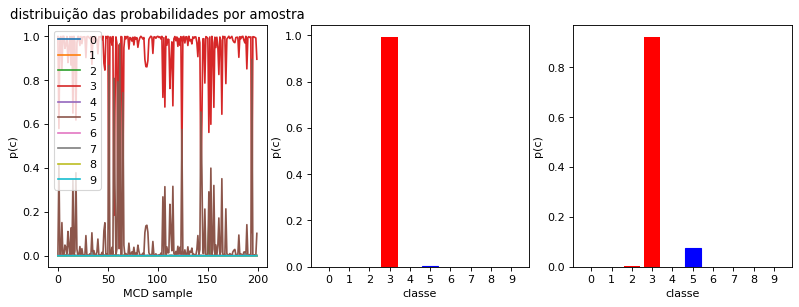

In [25]:
for s in np.random.randint(1000, size=10):
    sample = mc_preds[:,s,:]
    figure(figsize=(12, 4), dpi=80)
    plt.subplot(1,3,1)
    for i in range(mc_preds.shape[-1]):
        pc = sample[:,i]
        plt.plot(pc,label = f'{i}')
    #plt.xticks(range(n_samples))
    plt.xlabel('MCD sample')
    plt.ylabel('p(c)')
    plt.title('distribuição das probabilidades por amostra')

    plt.legend(loc='upper left')
    plt.subplot(1,3,2)
    barlist=plt.bar(range(10),preds[s].detach().numpy(),color = 'red')
    barlist[label[s]].set_color('b')
    plt.xticks(range(10))
    plt.xlabel('classe')
    plt.ylabel('p(c)')

    plt.subplot(1,3,3)
    barlist=plt.bar(range(10),means[s],color = 'red')
    barlist[label[s]].set_color('b')
    plt.xticks(range(10))
    plt.xlabel('classe')
    plt.ylabel('p(c)')

    plt.show()

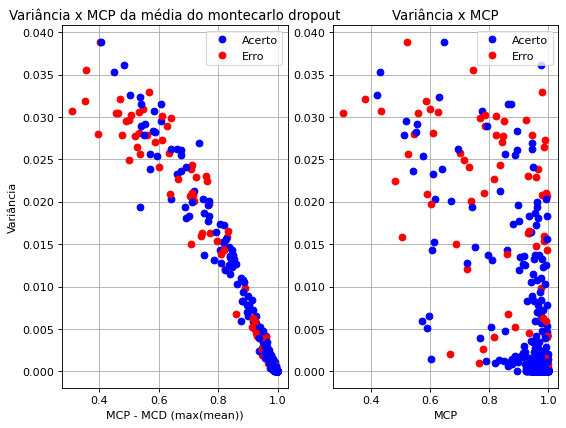

In [16]:


figure(figsize=(8, 6), dpi=80)

plt.subplot(1, 2, 1)
for i,guess in enumerate(guesses.numpy()):
    if guess == label[i]:
        plt.plot(maxes[i],var[i],'bo', label = 'Acerto')
    else:
        plt.plot(maxes[i],var[i],'ro', label = 'Erro')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("Variância")
plt.xlabel("MCP - MCD (max(mean))")
plt.title("Variância x MCP da média do montecarlo dropout")
plt.grid()

plt.subplot(1, 2, 2)
for i,guess in enumerate(guesses.numpy()):
    if guess == label[i]:
        plt.plot(MCP[i],var[i],'bo', label = 'Acerto')
    else:
        plt.plot(MCP[i],var[i],'ro', label = 'Erro')
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
#plt.ylabel("Variância")
plt.xlabel("MCP")
plt.title("Variância x MCP")
plt.grid()
plt.show()

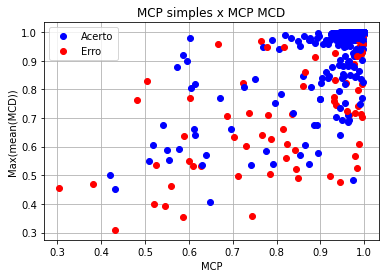

In [17]:
for i,guess in enumerate(guesses.numpy()):
    if guess == label[i]:
        plt.plot(MCP[i],maxes[i],'bo', label = 'Acerto')
    else:
        plt.plot(MCP[i],maxes[i],'ro', label = 'Erro')
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.ylabel("Max(mean(MCD))")
plt.xlabel("MCP")
plt.title("MCP simples x MCP MCD")
plt.grid()
plt.show()

In [31]:
prob_dif = prob_wrong(mc_preds,guesses)
prob_dif_mcp = prob_dif*MCP

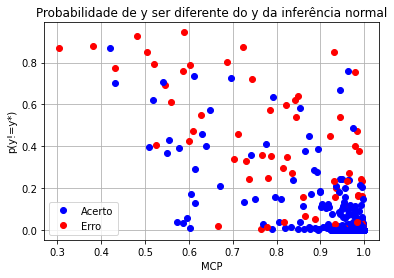

In [28]:
for i,guess in enumerate(guesses.numpy()):
    if guess == label[i]:
        plt.plot(MCP[i],prob_dif[i],'bo', label = 'Acerto')
    else:
        plt.plot(MCP[i],prob_dif[i],'ro', label = 'Erro')
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("MCP")
plt.ylabel("p(y!=y*)")
plt.title("Probabilidade de y ser diferente do y da inferência normal")
plt.grid()
plt.show()

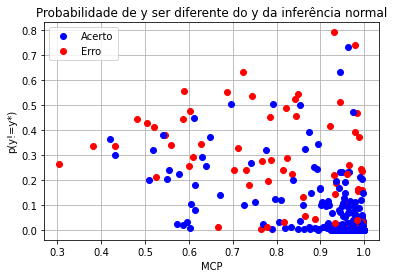

In [32]:
for i,guess in enumerate(guesses.numpy()):
    if guess == label[i]:
        plt.plot(MCP[i],prob_dif_mcp[i],'bo', label = 'Acerto')
    else:
        plt.plot(MCP[i],prob_dif_mcp[i],'ro', label = 'Erro')
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("MCP")
plt.ylabel("p(y!=y*)")
plt.title("Probabilidade de y ser diferente do y da inferência normal")
plt.grid()
plt.show()

In [ ]:
#output,label  = TE_g.accumulate_results_g(model,test_dataloader)

In [52]:
ent = entropy(preds).detach().numpy()
ent_means_mcd = entropy(means).detach().numpy()
mean_ent_mcd = torch.mean(entropy(mc_preds),dim = 0).detach().numpy()

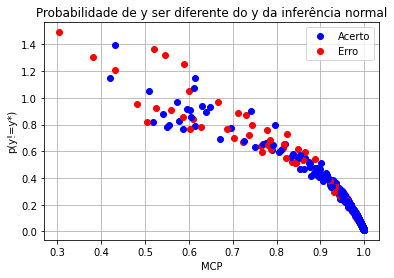

In [41]:
for i,guess in enumerate(guesses.numpy()):
    if guess == label[i]:
        plt.plot(MCP[i],ent[i],'bo', label = 'Acerto')
    else:
        plt.plot(MCP[i],ent[i],'ro', label = 'Erro')
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("MCP")
plt.ylabel("p(y!=y*)")
plt.title("Probabilidade de y ser diferente do y da inferência normal")
plt.grid()
plt.show()

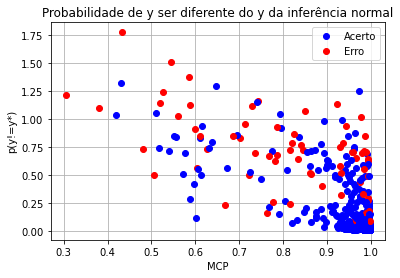

In [53]:
for i,guess in enumerate(guesses.numpy()):
    if guess == label[i]:
        plt.plot(MCP[i],ent_means_mcd[i],'bo', label = 'Acerto')
    else:
        plt.plot(MCP[i],ent_means_mcd[i],'ro', label = 'Erro')
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("MCP")
plt.ylabel("p(y!=y*)")
plt.title("Probabilidade de y ser diferente do y da inferência normal")
plt.grid()
plt.show()

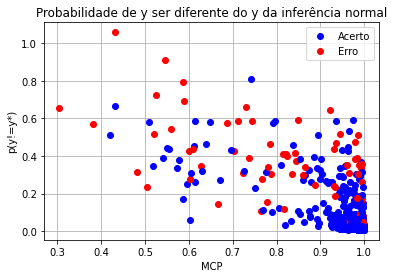

In [54]:
for i,guess in enumerate(guesses.numpy()):
    if guess == label[i]:
        plt.plot(MCP[i],mean_ent_mcd[i],'bo', label = 'Acerto')
    else:
        plt.plot(MCP[i],mean_ent_mcd[i],'ro', label = 'Erro')
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("MCP")
plt.ylabel("p(y!=y*)")
plt.title("Probabilidade de y ser diferente do y da inferência normal")
plt.grid()
plt.show()

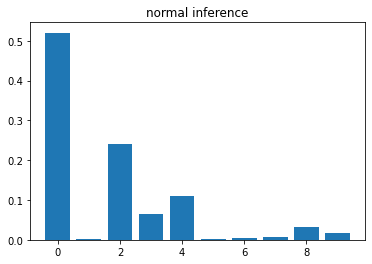

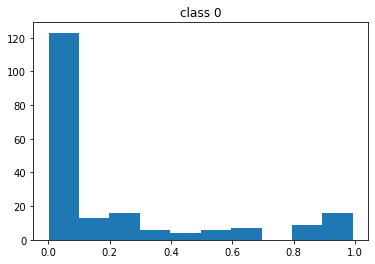

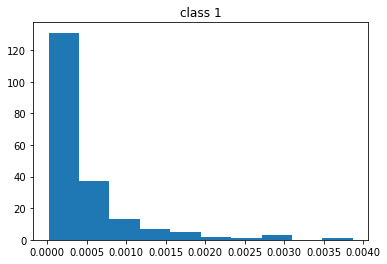

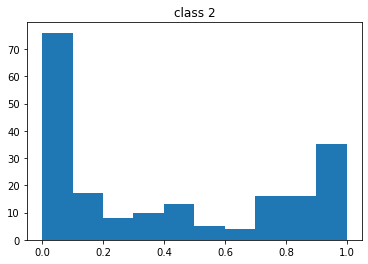

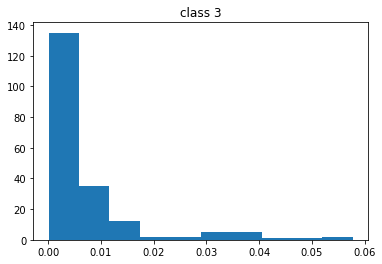

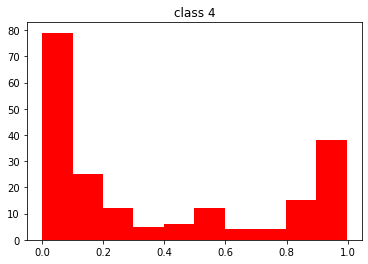

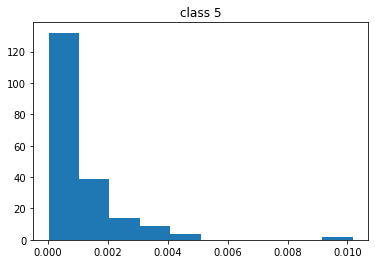

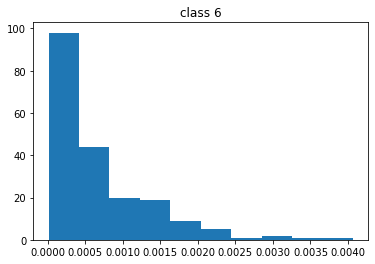

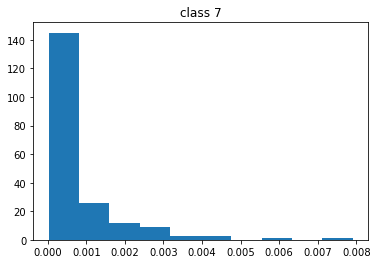

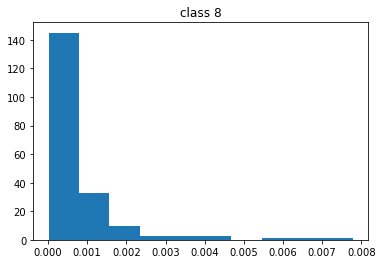

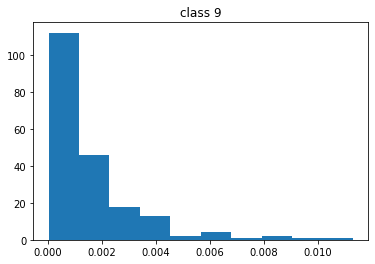

In [134]:
plt.bar(np.arange(10),preds[s,:].detach().numpy())
plt.title('normal inference')
plt.show()
s = torch.argmax(torch.mean(torch.var(mc_preds,dim=0),dim=-1))
for i in range(10):
    if i == label[s]: plt.hist(mc_preds[:,s,i].numpy(),color = 'red')
    else: plt.hist(mc_preds[:,s,i].numpy())
    plt.title(f'class {i}')
    plt.show()